# DDPM forward and reverse process implementation
Paper: https://arxiv.org/abs/2006.11239

## Forward Process
Fowrad process adss noise to the data


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!CUDA_LAUNCH_BLOCKING=1

In [3]:
import math
import torch
from torch import nn
from inspect import isfunction

class UNet(nn.Module):
    def __init__(
        self,
        in_channel=6,
        out_channel=3,
        inner_channel=32,
        norm_groups=32,
        channel_mults=(1, 2, 4, 8, 8),
        attn_res=(8),
        res_blocks=3,
        dropout=0,
        with_noise_level_emb=True,
        image_size=128,
        eps=1e-5
    ):
        super().__init__()

        if with_noise_level_emb:
            noise_level_channel = inner_channel
            self.noise_level_mlp = nn.Sequential(
                PositionalEncoding(inner_channel),
                nn.Linear(inner_channel, inner_channel * 4),
                Swish(),
                nn.Linear(inner_channel * 4, inner_channel)
            )
        else:
            noise_level_channel = None
            self.noise_level_mlp = None

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = image_size
        downs = [nn.Conv2d(in_channel, inner_channel,
                           kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResnetBlocWithAttn(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups, dropout=dropout, with_attn=use_attn, eps=eps))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=True, eps=eps),
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=False, eps=eps)
        ])

        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResnetBlocWithAttn(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                        dropout=dropout, with_attn=use_attn, eps=eps))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, default(out_channel, in_channel), groups=norm_groups, eps=eps)

    def forward(self, x, time):
        t = self.noise_level_mlp(time) if exists(
            self.noise_level_mlp) else None

        feats = []
        for layer in self.downs:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)

        for layer in self.ups:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)


# PositionalEncoding Source： https://github.com/lmnt-com/wavegrad/blob/master/src/wavegrad/model.py
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype, device=noise_level.device) / count
        encoding = noise_level.unsqueeze(1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat([torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding


class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(
            nn.Linear(in_channels, out_channels*(1+self.use_affine_level))
        )

    def forward(self, x, noise_embed):
        batch = x.shape[0]
        if self.use_affine_level:
            gamma, beta = self.noise_func(noise_embed).view(batch, -1, 1, 1).chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + self.noise_func(noise_embed).view(batch, -1, 1, 1)
        return x


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0, eps=1e-5):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim, eps=eps),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, use_affine_level=False, norm_groups=32, eps=1e-5):
        super().__init__()
        self.noise_func = FeatureWiseAffine(noise_level_emb_dim, dim_out, use_affine_level)

        self.block1 = Block(dim, dim_out, groups=norm_groups, eps=eps)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout, eps=eps)
        self.res_conv = nn.Conv2d(
            dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        b, c, h, w = x.shape
        h = self.block1(x)
        h = self.noise_func(h, time_emb)
        h = self.block2(h)
        return h + self.res_conv(x)


class SelfAttention(nn.Module):
    def __init__(self, in_channel, n_head=1, norm_groups=32, eps=1e-5):
        super().__init__()

        self.n_head = n_head

        self.norm = nn.GroupNorm(norm_groups, in_channel, eps=eps)
        self.qkv = nn.Conv2d(in_channel, in_channel * 3, 1, bias=False)
        self.out = nn.Conv2d(in_channel, in_channel, 1)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_head = self.n_head
        head_dim = channel // n_head

        norm = self.norm(input)
        qkv = self.qkv(norm).view(batch, n_head, head_dim * 3, height, width)
        query, key, value = qkv.chunk(3, dim=2)  # bhdyx

        attn = torch.einsum("bnchw, bncyx -> bnhwyx", query, key).contiguous() / math.sqrt(channel)
        attn = attn.view(batch, n_head, height, width, -1)
        attn = torch.softmax(attn, -1)
        attn = attn.view(batch, n_head, height, width, height, width)

        out = torch.einsum("bnhwyx, bncyx -> bnchw", attn, value).contiguous()
        out = self.out(out.view(batch, channel, height, width))

        return out + input


class ResnetBlocWithAttn(nn.Module):
    def __init__(self, dim, dim_out, *, noise_level_emb_dim=None, norm_groups=32, dropout=0, with_attn=False, eps=1e-5):
        super().__init__()
        self.with_attn = with_attn
        self.res_block = ResnetBlock(
            dim, dim_out, noise_level_emb_dim, norm_groups=norm_groups, dropout=dropout, eps=eps)
        if with_attn:
            self.attn = SelfAttention(dim_out, norm_groups=norm_groups, eps=eps)

    def forward(self, x, time_emb):
        x = self.res_block(x, time_emb)
        if(self.with_attn):
            x = self.attn(x)
        return x


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

In [ ]:
from numpy import mean, var


def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas

def make_beta_schedule(schedule, n_timestep, linear_start=1e-6, linear_end=1e-2, cosine_s=8e-3):
    """
    Create a beta schedule that is a function of the number of diffusion steps.
    Return:
        betas: a numpy array of shape (n_timestep,) that defines the beta schedule
    """
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return torch.from_numpy(betas)


class DenoiseDiffusion:
    def __init__(self, eps_model, beta_schedule, device, loss_fn=nn.L1Loss()):
        super().__init__()
        # Parameters for training
        self.device = device
        self.loss_fn = loss_fn
        self.eps_model = eps_model.to(device)
        self.beta_schedule = beta_schedule


        # Parameters for diffusion process
         

    def set_new_noise_schedule(self, phase='train'):
        beta = make_beta_schedule(**self.beta_schedule[phase])
        self.betas = beta.to(self.device, dtype=torch.float32)
        self.alphas = 1. - self.betas
        self.gammas = torch.cumprod(self.alphas, dim=0)
        self.n_steps = self.beta_schedule[phase]['n_timestep']
        self.sigma2 = self.betas  

    def gather(self, tensor, t):
        """
        Gather the values of x at the time steps t.
        Makes it compatible with the shape of x0, which is (B, C, H, W).
        Args:
            tensor: a tensor of shape (n_steps,)
            t: a tensor of shape (B,)
        Return:
            a tensor of shape (B, 1, 1, 1) that contains the values of x at the time steps t
        """
        t = tensor.gather(-1, t)
        return t.reshape(-1, 1, 1, 1)

    # We need a function that samples the batch 
    def q_sample(self, y0, sample_gammas, noise=None):
        """
        Sample from q(yt|y0), reading same as sample xt at step t given x0.
        Other implementations also use function q_xt_x0 first but we can directly implement it here.
        Args:
            y0: the original data, shape (B, C, H, W)
            sample_gammas: the gamma values for sampling, shape (B,)
            noise: the noise, shape (B, C, H, W)
        Return:
            yt: the noisy data at time step t, shape (B, C, H, W)
        """
        eps = torch.randn_like(y0) if noise is None else noise
        
        return (
            torch.sqrt(sample_gammas) * y0 + torch.sqrt(1 - sample_gammas) * eps
        )


    def p_sample(self, yt, t, clip_denoised=True):
        """
        Sample from p(yt-1|yt), reading same as sample yt-1 at step t given yt.
        Aka the denoising step.
        Args:
            yt: the noisy data at time step t, shape (B, C, H, W)
            t: the time step, shape (B,)
            clip_denoised: whether to clip the denoised data to [-1, 1]
        Return:
            yt_1: the denoised data at time step t-1, shape (B, C, H, W)
        """
        noise_level = self.gather(self.gammas, t).to(yt.device)
        sqrt_recip_gamma = torch.sqrt(1. / noise_level)
        sqrt_recipm1_gamma = torch.sqrt(1. / noise_level - 1)

        noise_pred = self.eps_model(yt, noise_level)
        y0_hat = sqrt_recip_gamma * yt - sqrt_recipm1_gamma * noise_pred

        if clip_denoised:
            y0_hat = torch.clamp(y0_hat, -1., 1.)
        
        posterior_mean_coef1 = self.gather(self.betas, t - 1) * torch.sqrt(self.gather(self.gammas, t - 1)) / (1. - self.gather(self.gammas, t))
        posterior_mean_coef2 = (1. - self.gather(self.gammas, t - 1)) * torch.sqrt(self.gather(self.alphas, t)) / (1. - self.gather(self.gammas, t))

        posterior_mean = posterior_mean_coef1 * y0_hat + posterior_mean_coef2 * yt

        posterior_variance = torch.maximum(
            self.gather(self.betas, t) * (1. - self.gather(self.gammas, t - 1)) / (1. - self.gather(self.gammas, t)),
            torch.tensor(1e-20, device=self.device),
        )

        eps = torch.randn_like(yt) if any(t > 1) else torch.zeros_like(yt)
        return posterior_mean + torch.sqrt(posterior_variance) * eps, noise_pred

    def forward(self, y0):
        """
        Algorithm 1 in Denoising Diffusion Probalisitic Models

        Args:
            y0: the original data, shape (B, C, H, W)
        """
        b, *_ = y0.shape

        t = torch.randint(1, self.n_steps, (b,), device=y0.device, dtype=torch.long)
        # Select a random gamma for each sample in the batch, which is between gamma_t and gamma_t-1 of generated timesteps t. This is to make the training more stable and avoid overfitting to specific timesteps.
        gamma_t1 = self.gather(self.gammas, t - 1)
        gamma_t2 = self.gather(self.gammas, t)
        sample_gammas = (gamma_t2 - gamma_t1) * torch.rand((b, 1, 1, 1), device=y0.device) + gamma_t1
        sample_gammas = sample_gammas

        # Create the noise to compare it to the predicted noise, which is used for training the model. This is the noise added to the original data to get the noisy data at time step t.
        noise = torch.randn_like(y0)
        y_noisy = self.q_sample(y0, sample_gammas, noise=noise)

        noise_hat = self.eps_model(y_noisy, sample_gammas)

        loss = self.loss_fn(noise_hat, noise)
        return loss
    


    # Solvers
    @torch.no_grad()
    def ddpm_sampler_palette(self, n_samples, sample_inter=10):
        # This doesn't work for some reason, I am skipping it.
        y = torch.randn(n_samples, 1, 64, 64, device=self.device)
        ret_arr = y.clone()
        for i in tqdm(reversed(range(1, self.n_steps)), desc='Sampling loop timestep', total=self.n_steps-1):
            t_tensor = torch.full((n_samples,), i, device=self.device, dtype=torch.long)
            y, _ = self.p_sample(y, t_tensor)
            if i & sample_inter == 0:
                ret_arr = torch.cat((ret_arr, y), dim=0)

        ret_arr = torch.cat((ret_arr, y), dim=0)
        
        return y, ret_arr


    @torch.no_grad()
    def ddpm_sampler(self, n_samples, sample_inter=10, clip_denoised=True):
        y = torch.randn(n_samples, 1, 64, 64, device=self.device)
        ret_arr = y.clone()
        for i in tqdm(reversed(range(1, self.n_steps)), desc='DDPM sampler', total=self.n_steps):
            z = torch.randn_like(y) if i > 1 else torch.zeros_like(y)   
            t_tensor = torch.full((n_samples,), i, device=self.device, dtype=torch.long)

            noise_level = self.gather(self.gammas, t_tensor).to(y.device)

            beta_t = self.gather(self.betas, t_tensor)
            alpha_t = self.gather(self.alphas, t_tensor)

            mean = 1 / torch.sqrt(alpha_t) * (y - ((1-alpha_t) / torch.sqrt(1 - noise_level)) * self.eps_model(y, noise_level))

            sigma = torch.sqrt(beta_t)

            y = mean + sigma * z

            if clip_denoised:
                y = torch.clamp(y, -1., 1.)

            if i & sample_inter ==0:
                ret_arr = torch.cat((ret_arr, y), dim=0)

        return y, ret_arr
    

    @torch.no_grad()
    def ddim_sampler(self, n_samples, noise=None, sample_inter=10, steps=50, clip_denoised=True, eta=0.0):
        """
        DDIM sampler from https://arxiv.org/abs/2010.02502
        With eta=0, it becomes a deterministic sampler, which is the one we will use in this implementation. With eta>0, it becomes a stochastic sampler, which is similar to the DDPM sampler but with different noise scale. 
        """
        y = torch.randn(n_samples, 1, 64, 64, device=self.device) if noise is None else noise
        ret_arr = y.clone()
        step_size = self.n_steps // steps

        for i in tqdm(range(steps), desc='DDIM sampling loop timestep', total=steps):
            t = self.n_steps - i * step_size
            t_tensor = torch.full((n_samples,), t, dtype=torch.long, device=self.device)

            gamma = self.gather(self.gammas, t_tensor - 1)
            
            # Make sure that when t_tensor - step_size - 1 is negative, we use gamma_prev = 1, which means that we are at the final step and we should not add any noise.
            gamma_prev = self.gather(self.gammas, t_tensor - step_size - 1) if t_tensor - step_size - 1 >= 0 else torch.ones_like(gamma)
            noise_pred = self.eps_model(y, gamma)

            y0_pred = (y - torch.sqrt(1 - gamma) * noise_pred) / torch.sqrt(gamma)
            
            # Clamp prediction to stablize sampling
            if clip_denoised:
                y0_pred = torch.clamp(y0_pred, -1., 1.)

            sigma_t = eta * torch.sqrt((1 - gamma_prev) / (1 - gamma)) * torch.sqrt(1-gamma / gamma_prev)

            dir_yt = torch.sqrt(1 - gamma_prev - torch.pow(sigma_t, 2)) * noise_pred
            
            
            y = torch.sqrt(gamma_prev) * y0_pred + dir_yt + sigma_t * torch.randn_like(y)

        return y, ret_arr

In [5]:
beta_schedule = dict(
    train=dict(
        schedule='linear',
        n_timestep=2000,
        linear_start=1e-6,
        linear_end=1e-2,
    ),
    test=dict(
        schedule='linear',
        n_timestep=1000,
        linear_start=1e-5,
        linear_end=1e-1,
    )
)

Unet = UNet(
        in_channel=1,
        out_channel=1,
        inner_channel=32,
        norm_groups=1,
        channel_mults=(1, 2, 4, 8),
        attn_res=[8],
        res_blocks=2,
        dropout=0,
        with_noise_level_emb=True,
        image_size=64,
        eps=1e-5)
diffusion = DenoiseDiffusion(Unet, beta_schedule, 'cuda:0')
diffusion.set_new_noise_schedule(phase='train')

In [6]:
size = 64
square_size = 16
tensor = torch.zeros(1, 1, size, size)
start = (size - square_size) // 2
end = start + square_size
tensor[:, :, start:end, start:end] = 1.0

samples = tensor.repeat(100, 1, 1, 1)
noise = torch.randn(1, 1, 64, 64, device='cuda:0')

DDIM sampling loop timestep:   0%|          | 0/10 [00:00<?, ?it/s]

DDIM sampling loop timestep: 100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


tensor([[[[ 1.0000,  0.0094, -0.4203,  ...,  0.4904, -0.9495,  0.3458],
          [ 1.0000,  0.9348, -0.8257,  ..., -0.8308,  0.2834,  0.9380],
          [ 1.0000,  1.0000, -0.2413,  ...,  0.3094, -1.0000,  0.4801],
          ...,
          [-0.4293, -0.6275,  0.9142,  ...,  0.8955, -0.2305,  0.8849],
          [-0.2098, -0.0306, -1.0000,  ...,  1.0000, -0.6199, -0.7076],
          [ 0.6682, -0.4801,  0.8121,  ...,  1.0000, -0.6182,  0.7615]]]],
       device='cuda:0')


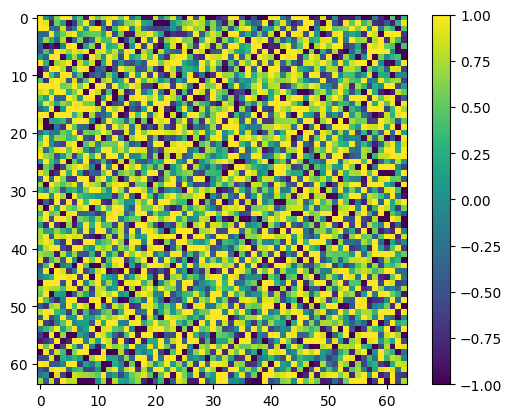

In [7]:
sampled = diffusion.ddim_sampler(1, noise=noise, steps=10, eta=1)
y, ret_arr = sampled
print(y)
plt.imshow(y.cpu().numpy()[0, 0], cmap='viridis')
plt.colorbar()

In [ ]:
# simple training loop using the existing `tensor` as toy data
device = diffusion.device
diffusion.eps_model.train()

optimizer = torch.optim.Adam(diffusion.eps_model.parameters(), lr=1e-4)

epochs = 15
steps_per_epoch = 50
batch_size = 64

for epoch in tqdm(range(epochs), desc='Training Epoch:', total=epochs):
    epoch_loss = 0.0
    for _ in range(steps_per_epoch):
        # repeat the toy sample to form a batch
        batch = tensor.repeat(batch_size, 1, 1, 1).to(device)
        optimizer.zero_grad()
        loss = diffusion.forward(batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"epoch {epoch+1}/{epochs} - loss: {epoch_loss/steps_per_epoch:.6f}")

Training Epoch::   7%|▋         | 1/15 [00:14<03:17, 14.09s/it]

epoch 1/15 - loss: 0.062991


Training Epoch::  13%|█▎        | 2/15 [00:27<03:00, 13.87s/it]

epoch 2/15 - loss: 0.050380


Training Epoch::  20%|██        | 3/15 [00:41<02:45, 13.76s/it]

epoch 3/15 - loss: 0.046805


Training Epoch::  27%|██▋       | 4/15 [00:54<02:30, 13.68s/it]

epoch 4/15 - loss: 0.043668


Training Epoch::  33%|███▎      | 5/15 [01:08<02:16, 13.66s/it]

epoch 5/15 - loss: 0.041732


Training Epoch::  40%|████      | 6/15 [01:22<02:02, 13.64s/it]

epoch 6/15 - loss: 0.039391


Training Epoch::  47%|████▋     | 7/15 [01:35<01:48, 13.61s/it]

epoch 7/15 - loss: 0.038934


Training Epoch::  53%|█████▎    | 8/15 [01:49<01:35, 13.62s/it]

epoch 8/15 - loss: 0.035724


Training Epoch::  60%|██████    | 9/15 [02:03<01:22, 13.82s/it]

epoch 9/15 - loss: 0.033902


Training Epoch::  67%|██████▋   | 10/15 [02:17<01:08, 13.76s/it]

epoch 10/15 - loss: 0.032737


Training Epoch::  73%|███████▎  | 11/15 [02:30<00:54, 13.67s/it]

epoch 11/15 - loss: 0.030905


Training Epoch::  80%|████████  | 12/15 [02:44<00:40, 13.64s/it]

epoch 12/15 - loss: 0.029135


In [9]:

diffusion.set_new_noise_schedule(phase='test')
y_ddpm, _ = diffusion.ddpm_sampler(1)
y_ddim, _ = diffusion.ddim_sampler(1, steps=10)



DDIM sampling loop timestep: 100%|██████████| 10/10 [00:00<00:00, 28.90it/s]


In [16]:
noise = torch.randn(1, 1, 64, 64, device='cuda:0')
y_ddim, _ = diffusion.ddim_sampler(1, steps=10)

DDIM sampling loop timestep: 100%|██████████| 10/10 [00:00<00:00, 27.16it/s]


DDIM sampling loop timestep: 100%|██████████| 50/50 [00:01<00:00, 28.47it/s]


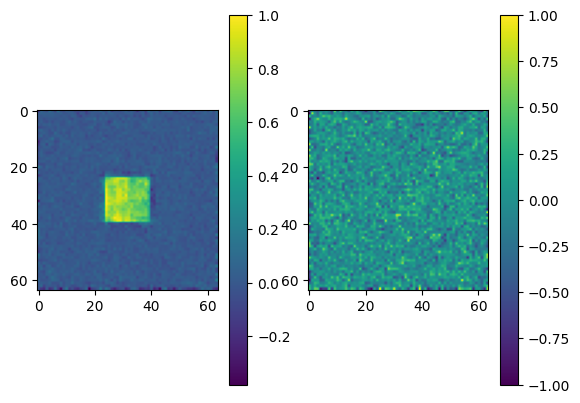

In [48]:
y_ddim, _ = diffusion.ddim_sampler(1, steps=50, eta=0.5)
fig, ax = plt.subplots(1, 2)

im0 = ax[0].imshow(y_ddpm.cpu().numpy()[0, 0], cmap='viridis')
im1 = ax[1].imshow(y_ddim.cpu().numpy()[0, 0], cmap='viridis')

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

plt.show()

In [12]:
print(y_ddim[:, :, start:end, start:end])

tensor([[[[-0.5760, -0.1620, -0.6697, -0.6734, -0.6176, -0.4840, -0.6028,
           -0.2646, -0.0248, -0.2590, -0.2525, -0.1209, -0.2401, -0.1839,
           -0.1107,  0.3099],
          [-0.3895, -0.4888, -0.2160, -0.5305, -0.5275, -0.7419, -0.5148,
           -0.6522, -0.0596, -0.4804, -0.4619, -0.4813, -0.1165, -1.1525,
           -0.5674,  0.3998],
          [-0.2089, -1.1550, -0.6830, -0.3973, -0.4252, -0.5968, -0.7239,
           -0.4583, -0.4985, -0.1989, -0.4479, -0.4047, -0.3798, -0.5950,
           -0.3563, -0.1938],
          [-1.1575, -0.4728, -0.3114, -0.4247, -0.5678, -0.5520, -0.5961,
           -0.4781, -0.5457, -0.3301, -0.1323, -0.4398, -0.4827, -0.4004,
            0.0247, -0.1685],
          [ 0.0477, -0.5711, -0.5933, -0.3806, -0.7619, -0.1280, -1.0516,
           -0.6297, -0.7132, -0.8186, -1.1520, -0.6135, -0.2577, -0.4066,
           -0.0238, -0.1967],
          [-0.5115, -0.4626, -0.5824, -1.1526, -0.6732, -1.1526, -0.7958,
           -0.5682, -0.4460, -0.4555